In [1]:
# Импортируем все необходимые зависимости
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

In [8]:
# Загрузка данных
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [9]:
# Общая информация о датасете
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [10]:
# Проверка наличия пропущенных значений
df.isnull().sum()

# Удаление строк с пропущенными значениями
df.dropna(inplace=True)

In [11]:
# Удаление строк с пропущенными значениями в столбце TotalCharges
df = df[df['TotalCharges'] != ' ']
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [12]:
# Преобразование категориальных признаков в числовые
label_encoder = LabelEncoder()
for column in df.select_dtypes(include=['object']).columns:
    if column != 'customerID':
        df[column] = label_encoder.fit_transform(df[column])

In [13]:
# Удаляем столбец customerID перед масштабированием
df = df.drop(['customerID'], axis=1)

# Масштабируем числовые признаки
scaler = StandardScaler()
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

In [15]:
# Разделение данных на обучающую и тестовую выборки
y = df['Churn']
X = df.drop('Churn', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Тренировка на тренирочных данных разных моделей и выбор оптимальной

In [16]:
# Обучение модели случайного леса
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
# Предсказание на тестовых данных
y_pred_rf = rf_model.predict(X_test)

# Обучение модели логистической регрессии
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)
# Предсказание на тестовых данных
y_pred_lr = lr_model.predict(X_test)

# Обучение модели градиентного бустинга
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
# Предсказание на тестовых данных
y_pred_gb = gb_model.predict(X_test)

## Оценка точности моделей

In [17]:
# Оценка точности случайного леса
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")
# Оценка точности логистической регрессии
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr}")
# Оценка точности градиентного бустинга
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Gradient Boosting Accuracy: {accuracy_gb}")

Random Forest Accuracy: 0.7917555081734187
Logistic Regression Accuracy: 0.7860696517412935
Gradient Boosting Accuracy: 0.7953091684434968


Исходя из точности моделей, выберем Градиентный бустинг, так как он показал наилучший результат на тестовой выборке

## Определение гиперпараметров для выбранной модели

In [18]:
# Определение параметров для GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.05],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10]
}
# Инициализация GridSearchCV
grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

# Обучение модели с подбором гиперпараметров
grid_search.fit(X_train, y_train)

# Вывод наилучших параметров
print("Best parameters found: ", grid_search.best_params_)

# Оценка модели с лучшими параметрами
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\Nicks1337\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found:  {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.9}
Accuracy: 0.7967306325515281


Лучшие гиперпараметры для данной модели такие: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 300, 'subsample': 0.9}. При подборе гиперпараметров точность на тестовой выборке увеличилась с 79,53% до 79,67%

## Построение матрицы ошибок и ROC-кривой для выбранной модели на основе работы с тестовыми данными

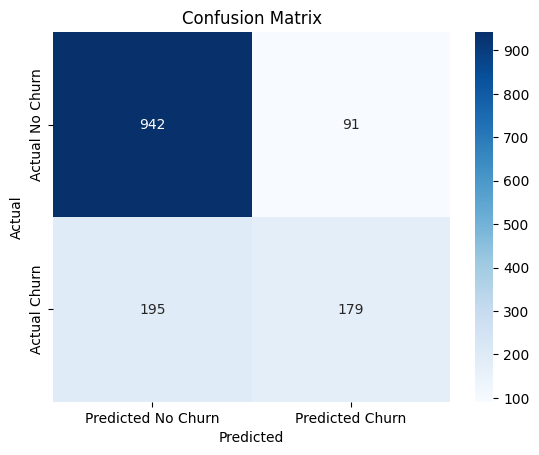

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1033
           1       0.66      0.48      0.56       374

    accuracy                           0.80      1407
   macro avg       0.75      0.70      0.71      1407
weighted avg       0.78      0.80      0.79      1407



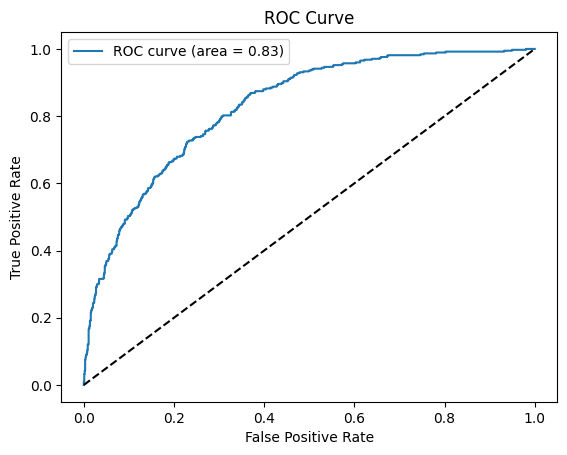

In [19]:
# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

# Визуализация матрицы ошибок
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No Churn', 'Predicted Churn'], yticklabels=['Actual No Churn', 'Actual Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Отчет о классификации
print(classification_report(y_test, y_pred))

# ROC-AUC кривая
y_pred_prob = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()


Исходя из того, что наша ROC-кривая проходит выше диагональной прямой, можно сделать вывод, что модель справляется лучше с предсказаниями, чем простое угадывание.

## Построение диаграммы важности признаков

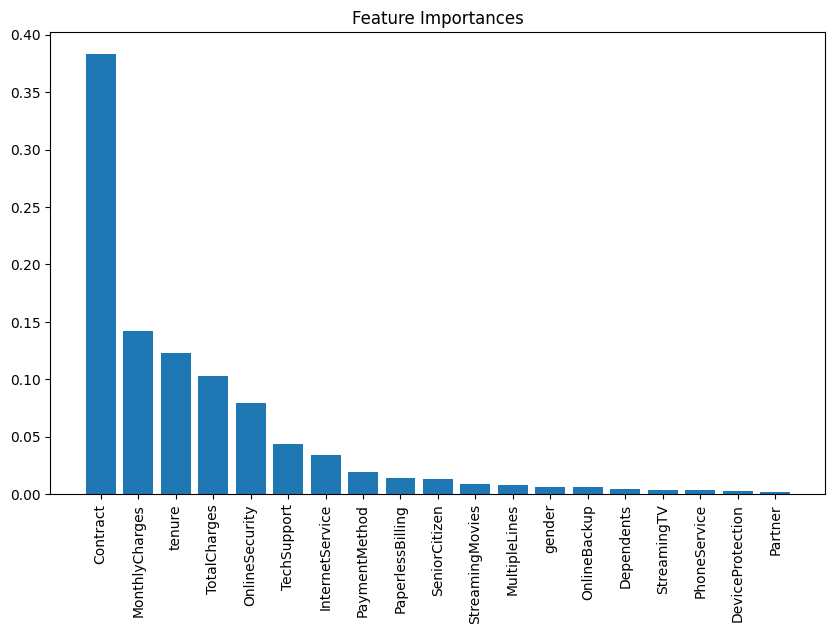

In [20]:
# Важность признаков
importances = best_model.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.show()

Наиболее важным признаком при предсказании модели является тип контракта, заключенного с клиентом: на месяц, год и т.д.